# Geo-Spatial Visualisation


## Introduction

In this chapter, you'll learn the basics of geospatial visualisation using code. If you're new to geospatial analysis, you should look at the introduction page first.

You should be aware when following this chapter that installing geographic analysis packages isn't always the easiest and things can and do go wrong! (Some geospatial analysis courses recommend running everything in a Docker container.)

### Imports and packages

We'll be using [**geopandas**](https://geopandas.org/index.html), the go-to package for vector spatial analysis in Python. The easiest way to install this package is using `conda install geopandas`; if you want to install it via pip then look at the [install instructions](https://geopandas.org/install.html). 

Let's import some of the packages we'll be using:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import geopandas as gpd
from pathlib import Path

In [2]:
# Set max rows displayed for readability
pd.set_option("display.max_rows", 6)
# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)
# For this page, use data limits and bigger default fig size
plt.style.use(
    {
        "axes.autolimit_mode": "data",
        "figure.figsize": (10, 8),
        "figure.dpi": 125,
        "patch.linewidth": 0.2,
    }
)

## Maps

If you've looked at the introductory page on geospatial analysis, you'll know it's easy to make basic maps: you just need to load a shapefile and use the `.plot` method.

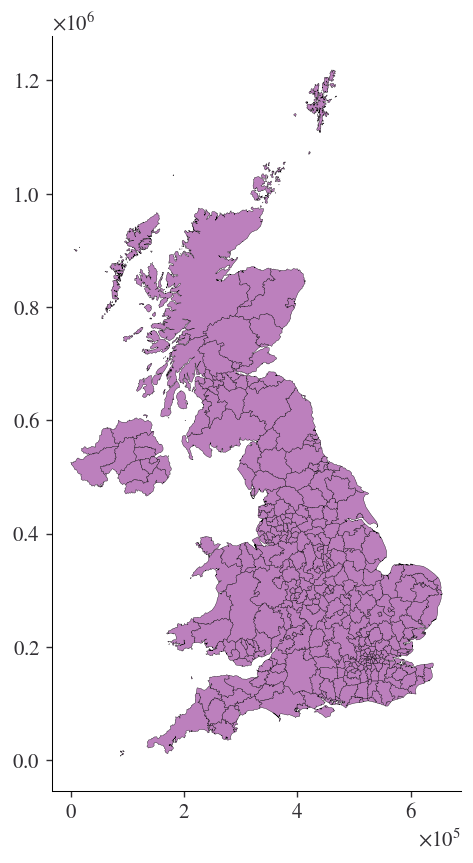

In [3]:
# To run this example, you will need to download the files at this url:
# https://github.com/aeturrell/coding-for-economists/tree/main/data/geo/uk_lad
# and save them in the path 'data/geo/uk_lad' (path relative to where you're running the code)
df = gpd.read_file(
    Path("data/geo/uk_lad/Local_Authority_Districts__May_2020__UK_BUC.shp")
)
df.plot();

As it goes, this is not very attractive, so let's see some options for customisation that will make it a little better. It's rare that you'll want to include the axes on maps, and these can be turned off by turning everything to do with the axes off. There are two ways to do further manipulations of the figure axis: calling plot returns an axis object or we can create one and then pass `ax=ax_name` to plot as a keyword argument. Colour can be changed using the `color=` keyword.

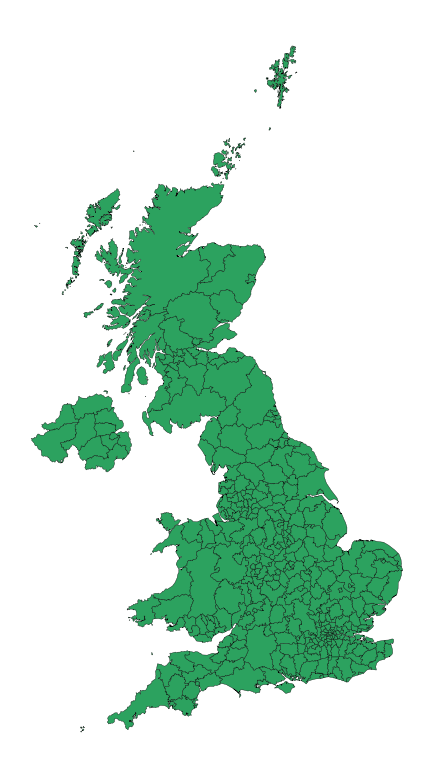

In [4]:
ax = df.plot(color="#2ca25f")
ax.axis("off");

The lines that divide up the different local authority districts are faint. They can be controlled with the `edgecolor` and `linewidth` keywords. We can also change the background using the `fig.patch.set_facecolor` method, and add a scale using an extra package, [**matplotlib-scalebar**](https://github.com/ppinard/matplotlib-scalebar).

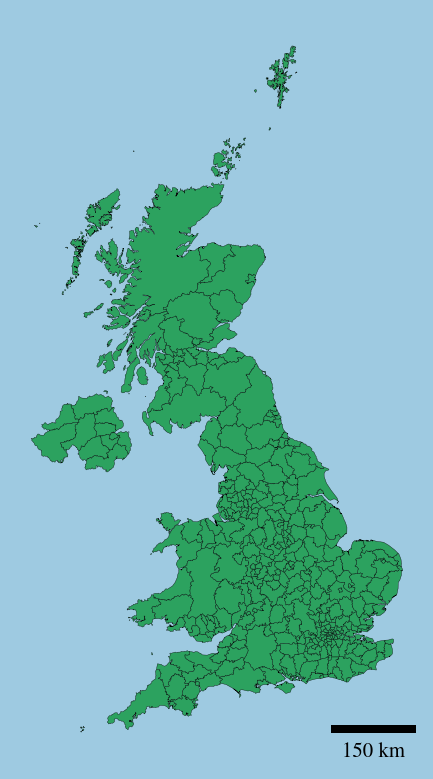

In [5]:
from matplotlib_scalebar.scalebar import ScaleBar

fig, ax = plt.subplots()
df.plot(color="#2ca25f", edgecolor="k", linewidth=0.2, facecolor="blue", ax=ax)
ax.axis("off")
fig.patch.set_facecolor("#9ecae1")
# Create scale bar
scalebar = ScaleBar(
    1,
    box_alpha=0,
    location="lower right",
    length_fraction=0.25,
    font_properties={"size": 12},
)
ax.add_artist(scalebar)
plt.show()

## Choropleths

A choropleth map shows different areas in colours according to a statistic that represents an aggregate summary of a geographic characteristic within each area. Population density or per-capita income are good examples of characteristics. The statistic shown might be unique values, equal intervals, quantiles, or the Fisher-Jenks natural breaks.

First, though, let's create a basic choropleth.

In [6]:
pay = pd.read_csv(
    "https://github.com/aeturrell/coding-for-economists/raw/main/data/geo/ashe_lad_median_pay_2020.csv"
)
pay = pay.rename(columns={"lad": "LAD20CD"})

In [7]:
df = df.merge(pay, on=["LAD20CD"], how="inner")

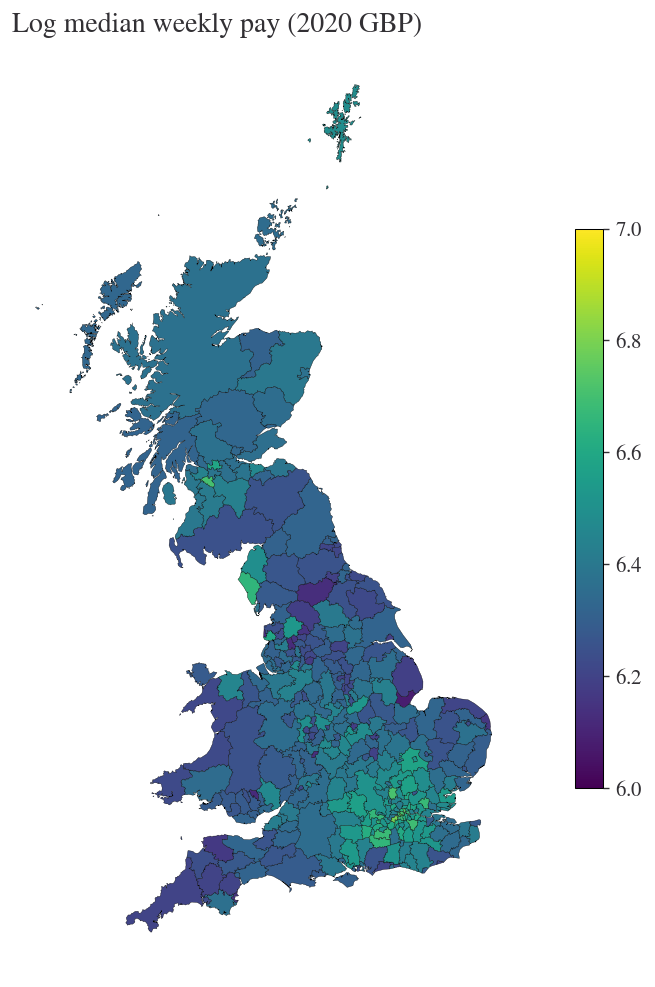

In [8]:
col = "Log median weekly pay (2020 GBP)"
df[col] = np.log(df["Median weekly pay (2020 GBP)"])

fig, ax = plt.subplots()
ax.set_title(col, loc="left")
df.plot(
    ax=ax,
    column=col,
    legend=True,
    legend_kwds={"label": "", "shrink": 0.6},
    vmin=round(df[col].min()),
    vmax=round(df[col].max()),
)
ax.axis("off")
plt.tight_layout()
plt.show();

This used **geopandas**. There's a dedicated plotting tool called [**geoplot**](https://residentmario.github.io/geoplot/index.html) as well.

/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/geoplot/geoplot.py:66: UserWarning: The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.
  warnings.warn(


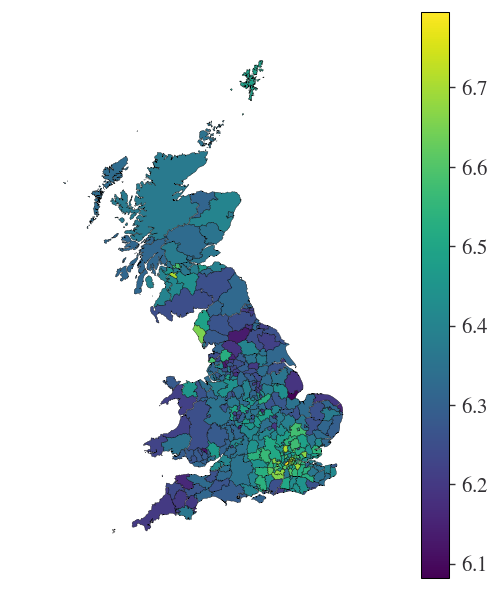

In [9]:
import geoplot as gplt
import geoplot.crs as gcrs

gplt.choropleth(
    df.to_crs("EPSG:4326"),
    hue=col,
    projection=gcrs.AlbersEqualArea(),
    cmap="viridis",
    legend=True,
);

Another way to create choropleths is to split the variable into a distinct number of ranges according to a scheme. In the below, we use `scheme='Quantiles'` with `k=4` to produce a choropleth with four distinct groups.

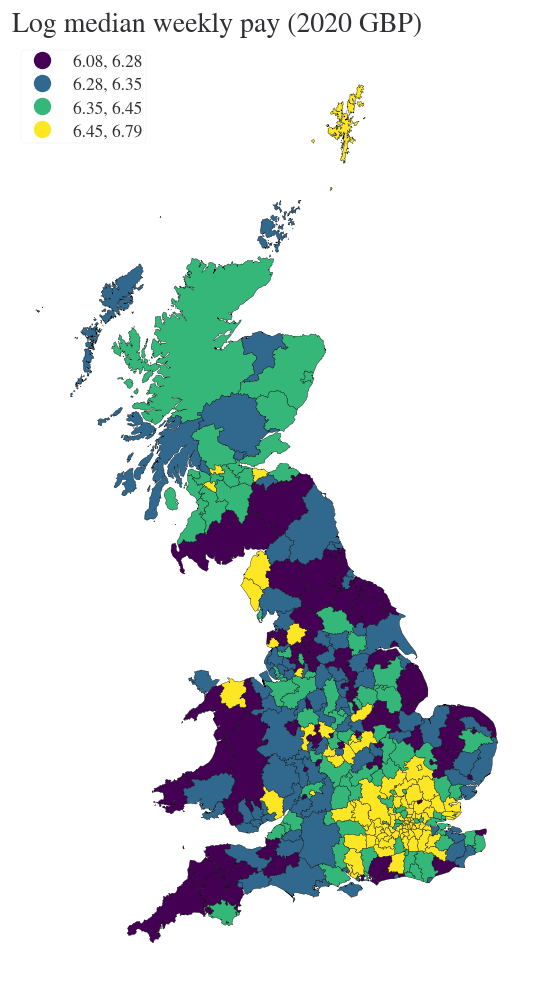

In [10]:
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_title(col, loc="left")
ax.axis("off")
df.plot(ax=ax, column=col, legend=True, scheme="Quantiles", k=4, legend_kwds={"loc": 2});

A third kind of choropleth has distinct levels based on pre-existing categories. Our data doesn't have any of those, so let's generate some just to show how it works.

In [11]:
df["cat_col"] = df["LAD20CD"].apply(lambda x: x[0])
df.iloc[:5, -3:]

Conf %  Log median weekly pay (2020 GBP) cat_col
0     6.5                          6.310100       E
1     7.5                          6.249010       E
2     8.6                          6.220391       E
3     6.3                          6.325434       E
4     7.7                          6.192158       E

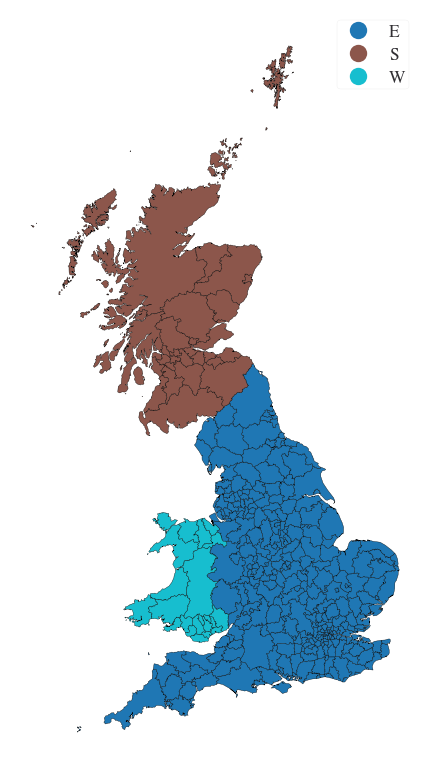

In [12]:
fig, ax = plt.subplots()
df.plot(
    column="cat_col",
    categorical=True,
    ax=ax,
    legend=True,
    legend_kwds={"loc": 1, "frameon": True},
)
ax.set_axis_off()
plt.show()

This is useful for, for example, plotting streets of different types.

## Cartogram

A cartogram is a thematic map in which the geographic size of regions is altered to be proportional to a variable. The shape of the region is warped or shrunk. They can be especially useful when trying to refectly the fact that regions with the largest area do not always have proportionate variable values. Actually, due to the tendency of the shape of political regions to reflect choices made 100s or 1000s of years previously, and for urban areas to be under separate political arrangements, quite often economic variables are anti-correlated with areas.

A cartogram of pay in Wales demonstrates this. Some areas with higer median incomes, such as Monmouthshire and Conwy, almost completely fill their potential region areas. But others, including Blaenau Gwent and Powys, are shown much smaller than their actual areas.

The important part of the plot below is the `gplt.cartogram` but, along with other bits to make the plot look better, we're adding `gplt.polyplot` to show what the true size of each region is when it is not proportional to another variable.

/var/folders/x6/ffnr59f116l96_y0q0bjfz7c0000gn/T/ipykernel_56683/3850178699.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if row["geometry"].area > np.quantile(df.area, q=0.7):


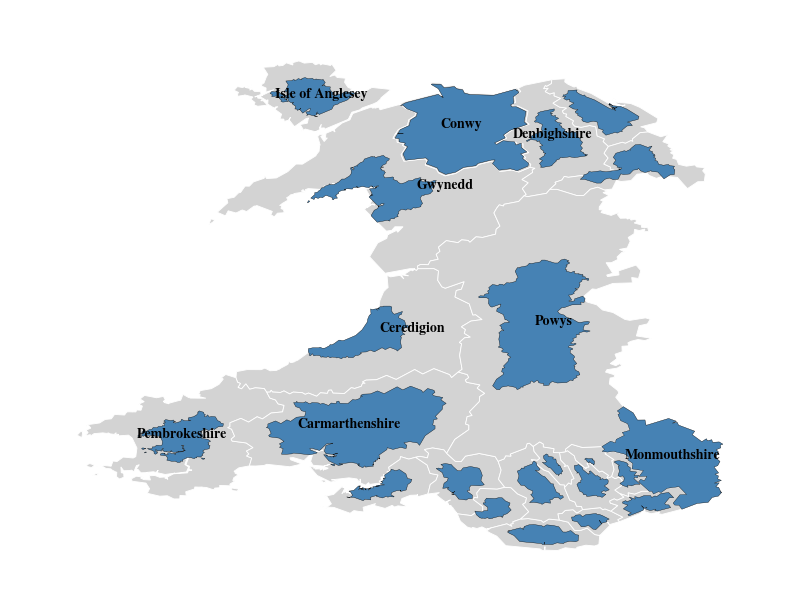

In [13]:
df = df.to_crs("EPSG:4326")
# Get a representative point for each region to annotate
df["coords"] = df["geometry"].representative_point().apply(lambda x: x.coords[:][0])
df_wales = df[df["LAD20CD"].str.contains("W")].fillna(0.0)

fig, ax = plt.subplots(figsize=(10, 5), dpi=125)
gplt.cartogram(df_wales, scale="Median weekly pay (2020 GBP)", ax=ax)
gplt.polyplot(df_wales, facecolor="lightgray", edgecolor="white", linewidth=0.5, ax=ax)
# Add text annotation to the largest polygons
for idx, row in df_wales.iterrows():
    if row["geometry"].area > np.quantile(df.area, q=0.7):
        ax.annotate(
            text=row["LAD20NM"],
            xy=row["coords"],
            horizontalalignment="center",
            weight="bold",
            fontsize=8,
            color="black",
        )
plt.tight_layout();

## Quadtree

A quadtree is a tree data structure that splits a space into increasingly small rectangular fractals. This plot takes a sequence of point or polygonal geometries as input and builds a choropleth out of their centroids. Quadtrees are good at illustrating density, and are more flexible than a conventional choropleth: remember that choropleths can be the result of binning point occurrences into geographical regions or of data that are already aggregated to the region level. Quadtree is not a replacement for the latter, because the data are already aggregated. But, if you have point data, quadtree allows you to aggregate them *not* according to a pre-defined geography. Given pre-defined geographies such as Local Authority Districts may not be useful for the question you're thinking about (or worse could be downright misleading), this is a very helpful property.

We'll use an example from the **geoplot** documentation to illustrate them. The most basic layer just turns a series of points into a quadtree. We'll use the lats and longs of collisions in New York:

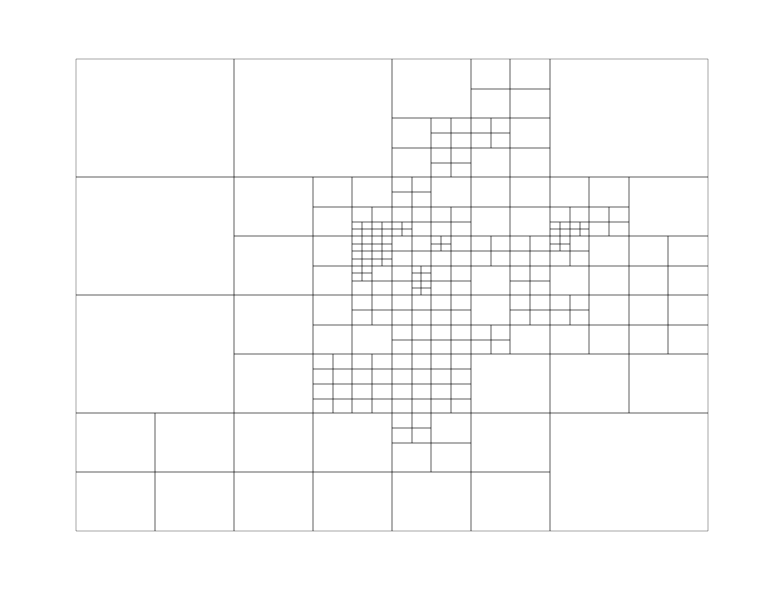

In [14]:
collisions = gpd.read_file(gplt.datasets.get_path("nyc_collision_factors"))
gplt.quadtree(collisions, nmax=1);

Now let's project this onto a background of NY's boroughs. Because this is computationally expensive, we'll use the `simplify` method to reduce the complexity of the geometries we're using.

/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/geopandas/geoseries.py:694: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return self.isna()


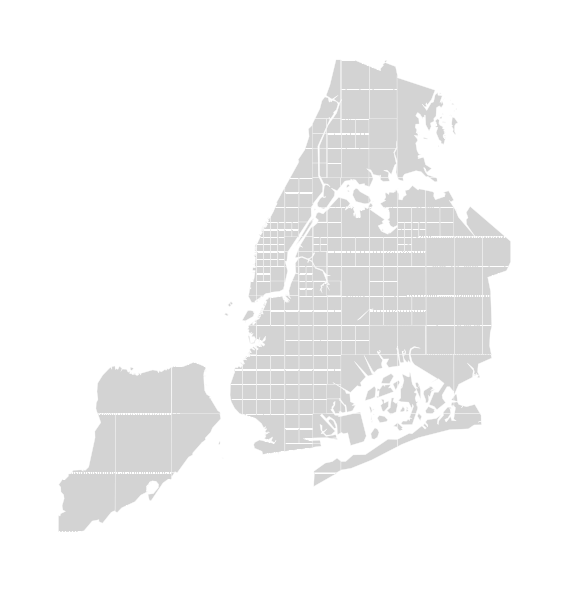

In [15]:
boroughs = gpd.read_file(gplt.datasets.get_path("nyc_boroughs"))
gplt.quadtree(
    collisions,
    nmax=1,
    projection=gcrs.AlbersEqualArea(),
    clip=boroughs.simplify(0.001),
    facecolor="lightgray",
    edgecolor="white",
);

We can enjoy the best of a choropleth's ability to show us magnitudes *alongside* the ability of quadtree to show us geographic density through smaller rectangles:

/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/geopandas/geoseries.py:694: UserWarning: GeoSeries.isna() previously returned True for both missing (None) and empty geometries. Now, it only returns True for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use 's.is_empty | s.isna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.isna', UserWarning)
  return self.isna()


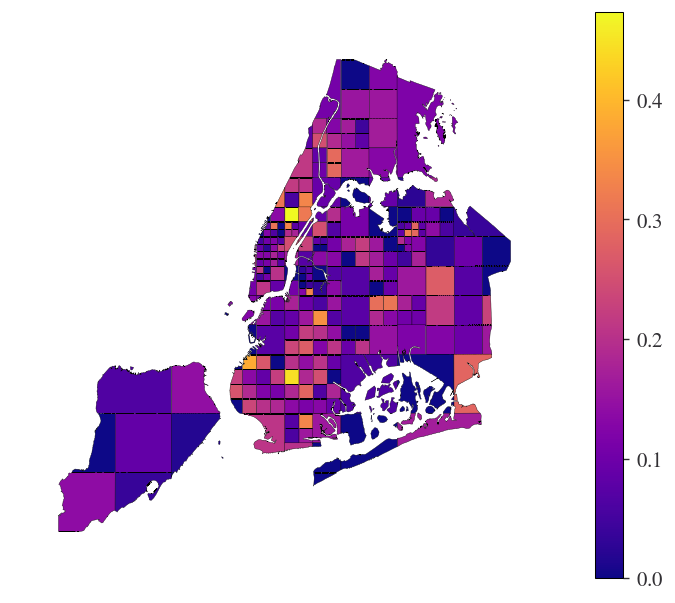

In [16]:
gplt.quadtree(
    collisions,
    nmax=1,
    agg=np.mean,
    projection=gcrs.AlbersEqualArea(),
    clip=boroughs,
    hue="NUMBER OF PEDESTRIANS INJURED",
    cmap="plasma",
    edgecolor="k",
    legend=True,
);

## KDE plot

You probably know kernel density estimation from 1D distribution functions, but there's no reason not to have the same fun in 2D. Taking the collisions data again, below is an example for New York. The `thresh=0` keyword argument just tells the KDE estimation to leave no empty whitespace where the estimated values are at their lowest.

/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


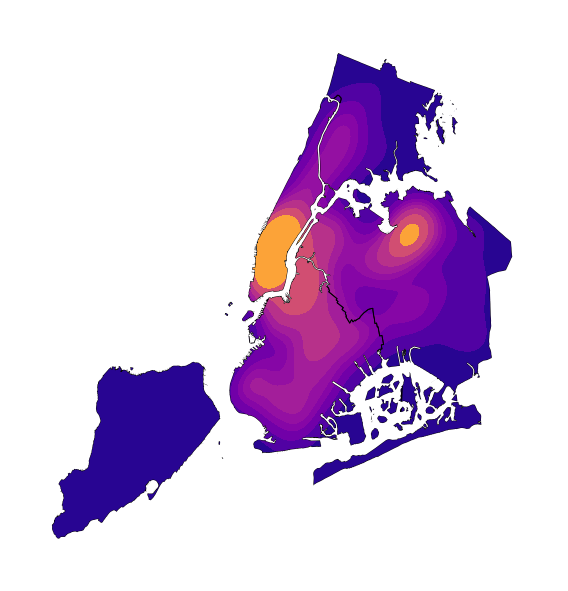

In [17]:
ax = gplt.polyplot(boroughs, projection=gcrs.AlbersEqualArea(), linewidth=0.5, zorder=1)
gplt.kdeplot(
    collisions, cmap="plasma", shade=True, thresh=0, clip=boroughs, ax=ax, zorder=0
);

## Spatio-Temporal Plots

This is really going to combine two things we already have at our fingertips: space and time. There are various ways we could approach this. The first we'll see is to do a series of *small multiples*, also known as a *facet chart*, and advance time by one unit in each plot. The second is just a heat map in which the two dimensions are space and time.

The data we'll be using tell a tragic story. They are counts of deaths that occurred within 28 days of (a known case of) coronavirus organised by the death date. Note that there are various issues with these data and they do not tell the whole story of coronavirus by any means. But this is just an illustrative example.

We'll just bring in data for London. They don't come with their own geometry, so our first job is to merge them onto our existing UK local authority geodataframe, which does have a geometry. Fortunately, both data sets have the 'LAD20CD' and 'LAD20NM' columns, which makes this easier than it might have been.

In [18]:
df = df[df["LAD20CD"].str.contains("E09")]
cv_df = pd.read_parquet(
    "https://github.com/aeturrell/coding-for-economists/raw/main/data/geo/cv_ldn_deaths.parquet"
)
df = df.merge(cv_df, on=["LAD20CD", "LAD20NM"], how="inner")
df.head()

OBJECTID    LAD20CD               LAD20NM LAD20NMW   BNG_E   BNG_N  \
0       283  E09000002  Barking and Dagenham     None  547757  185111   
1       283  E09000002  Barking and Dagenham     None  547757  185111   
2       283  E09000002  Barking and Dagenham     None  547757  185111   
3       283  E09000002  Barking and Dagenham     None  547757  185111   
4       283  E09000002  Barking and Dagenham     None  547757  185111   

       LONG      LAT    Shape__Are    Shape__Len  \
0  0.129479  51.5456  3.635701e+07  31245.950962   
1  0.129479  51.5456  3.635701e+07  31245.950962   
2  0.129479  51.5456  3.635701e+07  31245.950962   
3  0.129479  51.5456  3.635701e+07  31245.950962   
4  0.129479  51.5456  3.635701e+07  31245.950962   

                                            geometry                  name  \
0  POLYGON ((0.16012 51.51178, 0.15874 51.51227, ...  Barking and Dagenham   
1  POLYGON ((0.16012 51.51178, 0.15874 51.51227, ...  Barking and Dagenham   
2  POLYGON ((0.16012 51.51178, 0.15874 51.51227, ...  Barking and Dagenham   
3  POLYGON ((0.16012 51.51178, 0.15874 51.51227, ...  Barking and Dagenham   
4  POLYGON ((0.16012 51.51178, 0.15874 51.51227, ...  Barking and Dagenham   

   Median weekly pay (2020 GBP)  Conf %  Log median weekly pay (2020 GBP)  \
0                         609.1     5.7                          6.411982   
1                         609.1     5.7                          6.411982   
2                         609.1     5.7                          6.411982   
3                         609.1     5.7                          6.411982   
4                         609.1     5.7                          6.411982   

  cat_col                                    coords       date  \
0       E  (0.15149832858864332, 51.55501166518745) 2020-03-31   
1       E  (0.15149832858864332, 51.55501166518745) 2020-04-30   
2       E  (0.15149832858864332, 51.55501166518745) 2020-05-31   
3       E  (0.15149832858864332, 51.55501166518745) 2020-06-30   
4       E  (0.15149832858864332, 51.55501166518745) 2020-07-31   

   newDeaths28DaysByDeathDate  
0                          29  
1                          66  
2                           9  
3                           3  
4                           1

Now we will create the small multiple chart. There's quite a lot going on in the below so let's talk through the moving pieces. There's a perpectually uniform heatmap from the **colorcet** package that ranges between a min of 0 and max of 250 as set by `vmin` and `vmax`. To plot every one of the 12 time periods, `plt.subplots` is called with `nrows=4` and `ncols=3` for 12 axes in total. We `.flatten()` the axes to make it easier to iterate over them. We turn the legend off for all but one axis. With all of this set up, we iterate through the unique values of the date column, which is at monthly frequency, and plot each in turn on a separate axis oject. For each, we also add a title that is the month and year.

The overall effect is quite powerful: you can really see how deaths peaked around April 2020 and January 2021, having begun to pick up in November, but you can also see the long period of relatively few deaths 28 days after diagnosis during the summer months.

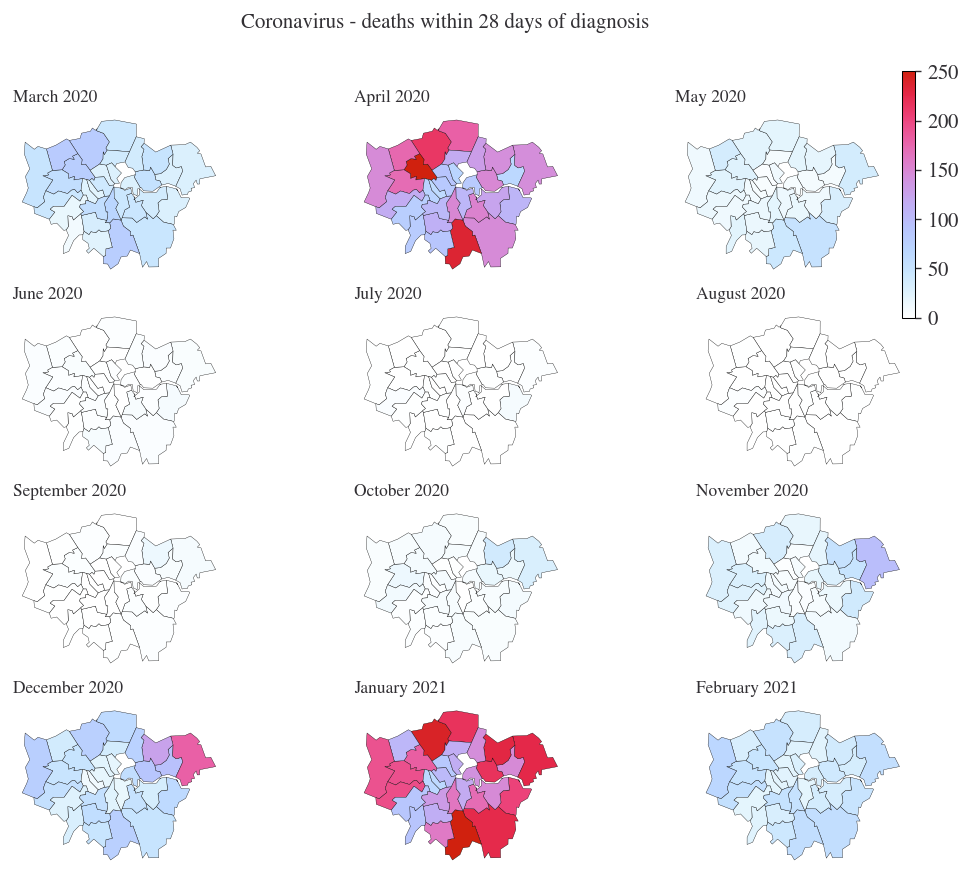

In [19]:
from datetime import datetime
import colorcet as cc

col = "newDeaths28DaysByDeathDate"

fig, axes = plt.subplots(nrows=4, ncols=3)
axes = axes.flatten()
legend_choice = [False] * len(axes)
legend_choice[2] = True
for i, date in enumerate(df["date"].unique()):
    df_cut = df[df["date"] == date]
    df_cut.plot(
        ax=axes[i],
        column=col,
        legend_kwds={"label": "", "shrink": 1.5},
        vmin=0,
        vmax=250,
        legend=legend_choice[i],
        cmap=cc.cm.CET_L19,
    )
    axes[i].axis("off")
    axes[i].set_title(pd.to_datetime(str(date)).strftime("%B %Y"), size=10)
plt.suptitle("Coronavirus - deaths within 28 days of diagnosis", size=12);

Another way to show time and space is using a heatmap. The easiest way to plot a heatmap is to put the data into wide format first. To ensure we have nice labels though, we're going to cast the datetime variable in a month and year in the format 'Jan 20' using `strftime` first.

In [20]:
df["Time"] = df.date.apply(lambda x: x.strftime("%b \n %y"))
hmap_df = df.pivot("Time", "LAD20NM", "newDeaths28DaysByDeathDate").T
# Puts the datetimes in the correct order
hmap_df = hmap_df[list(df["Time"].unique())]
hmap_df.head()

Time                  Mar \n 20  Apr \n 20  May \n 20  Jun \n 20  Jul \n 20  \
LAD20NM                                                                       
Barking and Dagenham         29         66          9          3          1   
Barnet                       81        213         22          0          0   
Bexley                       29        107         32          8          8   
Brent                        79        273         26          5          1   
Bromley                      46        146         51          4          0   

Time                  Aug \n 20  Sep \n 20  Oct \n 20  Nov \n 20  Dec \n 20  \
LAD20NM                                                                       
Barking and Dagenham          0          6         15         49         94   
Barnet                        0          2          8         34         76   
Bexley                        1          2          9         40         63   
Brent                         0          3          9         11         49   
Bromley                       0          2          5         10         49   

Time                  Jan \n 21  Feb \n 21  
LAD20NM                                     
Barking and Dagenham        147         35  
Barnet                      241         51  
Bexley                      204         48  
Brent                       182         47  
Bromley                     225         57

Now we have the data where we want it, we can call the `ax.imshow` method with a colourmap and set the labels to the index and columns in order to show how, for each London Borough, the number of deaths has changed over time. Note that, unlike the geospatial map, this does not capture the linkages in space very well: but it arguably does a better job of capturing linkages in time.

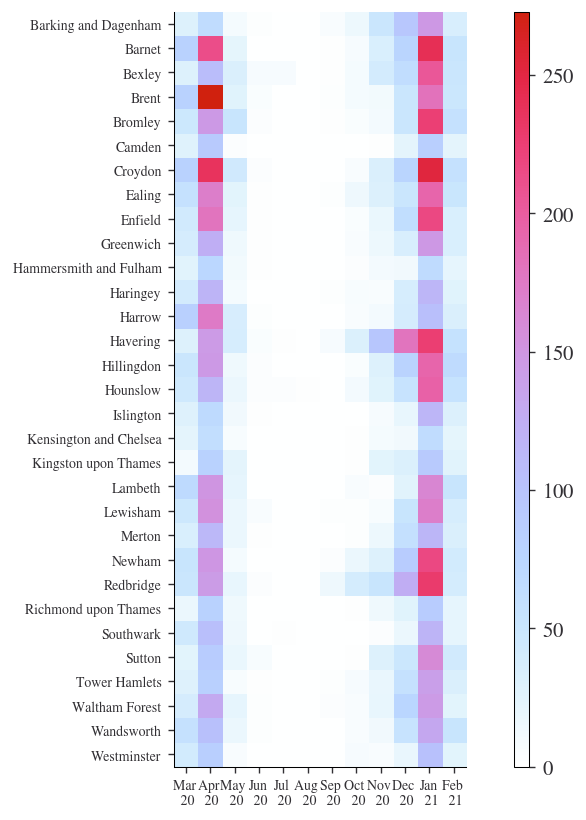

In [21]:
fig, ax = plt.subplots()
im = ax.imshow(hmap_df.values, cmap=cc.cm.CET_L19)
cbar = ax.figure.colorbar(im, ax=ax, aspect=50)
ax.set_xticks(np.arange(len(hmap_df.columns)))
ax.set_yticks(np.arange(len(hmap_df.index)))
# Labels
ax.set_xticklabels(hmap_df.columns, rotation=0, fontsize=8)
ax.set_yticklabels(hmap_df.index, fontsize=8)
plt.show()

## Using basemaps

All of the examples we've seen have just been lines around coloured polygons. This is, fortunately, not how most maps look. Instead, they have lots of detail or other features. Sometimes you want to incorporate other features into your map, or just give some context to where things are beyond the boundaries of your polygons. Enter different basemaps, ie different backgrounds for you to draw the geospatial data on top of.

There are a few options to do this. Let's begin with **geoplot**, the package from the examples above. It has projection called `WebMercator` that is a 'real' map. It's easiest to illustrate with an example; let's use Wales again. But the whole point is that we can combine this map with other things, so we'll do a few points to show where some places are: LLandudno, Cardiff, Rhyll, Newport, and St Davids. St Davids is the smallest city in Britain, and we'll make the points proportional to population, so you may have to squint to see it!

In [22]:
wales_places = {
    "name": ["Cardiff", "Llandudno", "Rhyl", "Newport", "St Davids"],
    "lat": [51.481583, 53.3241, 53.3191, 51.5842, 51.8812],
    "lon": [-3.179090, -3.8276, -3.4916, -2.9977, -5.2660],
    "pop": [335145, 20701, 25149, 145700, 1600],
}
wdf = pd.DataFrame(wales_places)
gwdf = gpd.GeoDataFrame(wdf, geometry=gpd.points_from_xy(wdf.lon, wdf.lat))
gwdf.head()

name        lat      lon     pop                   geometry
0    Cardiff  51.481583 -3.17909  335145  POINT (-3.17909 51.48158)
1  Llandudno  53.324100 -3.82760   20701  POINT (-3.82760 53.32410)
2       Rhyl  53.319100 -3.49160   25149  POINT (-3.49160 53.31910)
3    Newport  51.584200 -2.99770  145700  POINT (-2.99770 51.58420)
4  St Davids  51.881200 -5.26600    1600  POINT (-5.26600 51.88120)

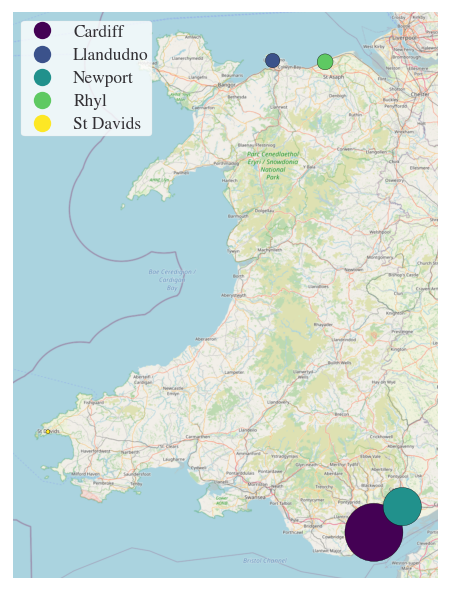

In [23]:
# Create basemap
ax = gplt.webmap(df_wales, projection=gcrs.WebMercator())
# Add points for places
gplt.pointplot(gwdf, ax=ax, hue="name", legend=True, sizes=gwdf["pop"] / 300);

### Contextily

**geoplot** has some basic functionality for basemaps but the [**contextlily**](https://contextily.readthedocs.io/en/latest/intro_guide.html) package provides a whole lot more flexibility and is solely focused on different 'context tiles' for your map. It's also designed to work with **geopandas** (it's built by the same people) and the syntax is quite similar to what you've seen already.

Let's see an example of it in action. We'll ask for a bounding box around a place we're interested in, London's Canary Wharf. The option that brings in different basemaps is the `source=` keyword argument. There are a range of sources of basemaps but the real magic is that, given a location, **contextily** *downloads a background map for you*. Pretty cool. There is a full list of providers [here](https://contextily.readthedocs.io/en/latest/providers_deepdive.html).

In [24]:
import contextily as cx

west, south, east, north = (-0.030251, 51.499019, 0.002017, 51.509511)
cw_img, cw_ext = cx.bounds2img(
    west, south, east, north, ll=True, source=cx.providers.Stamen.Toner
)

Because the map gets downloaded when you make this request, it takes a long time the first time it's run. But the map is locally cached so that, if you call the same function again, it will be much faster the second time. Let's plot the map out:

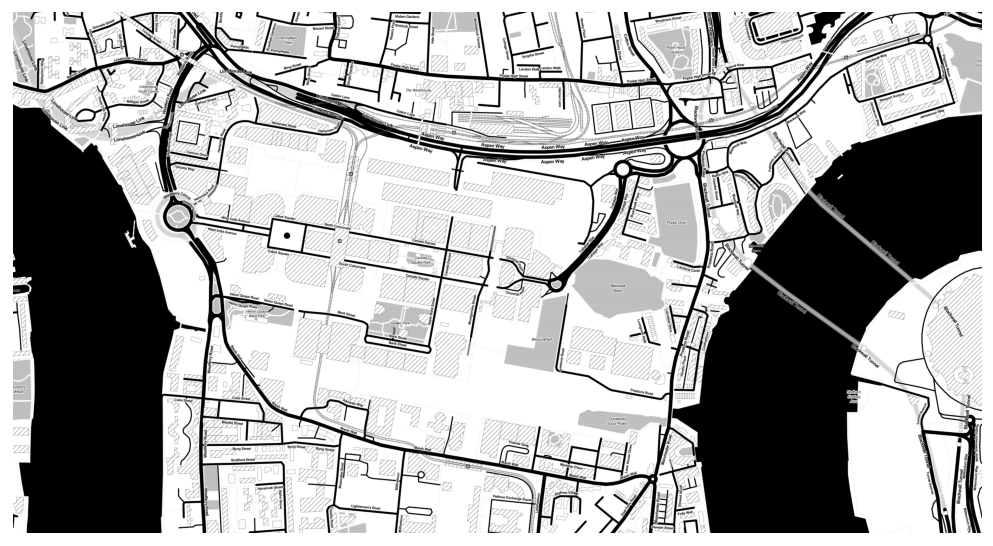

In [25]:
fig, ax = plt.subplots()
ax.axis("off")
ax.imshow(cw_img, extent=cw_ext);

You can also get a map through a text search, though be warned you may get another place with the same name in a different region. You can do this type of map-grab using `cx.Place("...", source=...)`.

Okay, it's great to download a map but what about combining it with some useful info? Well, we can do that too. Let's use **osmnx** to get some data on coffee shops in an area more tightly focused around Canary Wharf. We'll then pop these onto a map of the area.

In [26]:
import osmnx as ox

coffee_shops = ox.geometries_from_place(
    "Canary Wharf", tags={"amenity": "cafe"}, buffer_dist=300
)
coffee_shops = coffee_shops.to_crs("EPSG:3857")

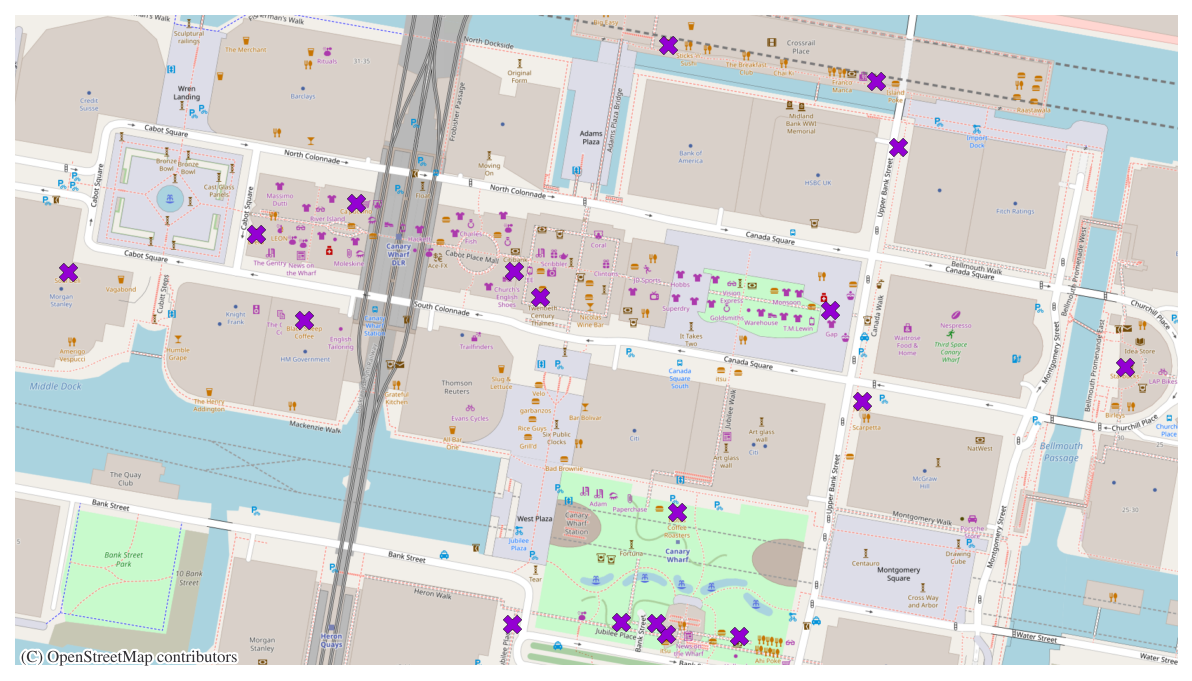

In [27]:
fig, ax = plt.subplots(dpi=150)
coffee_shops.plot(ax=ax, markersize=80, color="darkviolet", edgecolor="k", marker="X")
ax.axis("off")
cx.add_basemap(
    ax, crs=coffee_shops.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik
);

You can also add boundary and polygon objects to **contextily** basemaps.

## Interactive maps

We'll use [**folium**](https://python-visualization.github.io/folium/index.html), a wrapper for the leaflet javascript library, to create interactive maps that we can layer information on top of. The library has a number of built-in tilesets from OpenStreetMap, Mapbox, and Stamen, and supports custom tilesets too. If it has a disadvantage, it's that it doesn't play that nicely with **geopandas**. It isn't easy to create an interactive choropleth using a **geopandas** dataframe, for example. However, choropleths can be added as a layer from a URL that points to a geoJSON file.

In the simple example below, we'll do two things: create a basemap showing the City of London and add some markers to it that show new information on a mouse hover and when clicked. Let's put markers down for the places to get coffee in the serenity of a City church.

In [28]:
import folium

# create data for markers
caff_df = pd.DataFrame(
    {
        "name": ["Host Coffee", "Cosy Coffee Corner", "The Wren Coffee"],
        "loc": [[51.5128, -0.0933], [51.5128, -0.0882], [51.512106, -0.096870]],
    }
)
# create hover over marker msg
tooltip = "Click here."

# create map
m = folium.Map(location=[51.5128, -0.0933], zoom_start=16)
# add markers to map
for index, row in caff_df.iterrows():
    folium.Marker(row["loc"], popup=row["name"], tooltip=tooltip).add_to(m)
# show map
m

Folium can also be combined with a choropleth; see the [documentation](https://python-visualization.github.io/folium/quickstart.html#) for more information.

## Static maps

This is an honourable mention to [**py-staticmaps**](https://github.com/flopp/py-staticmaps), which provides the kind of tilesets we've seen already with **contextlily** and **folium** but includes easy methods to add:

- markers
- image (PNG) markers
- geodesic lines, i.e. the shortest path between two points given the geometry. These are *very* important in general relativity, where they appear as solutions to the geodesic equation  ${\displaystyle {d^{2}x^{\mu } \over ds^{2}}+\Gamma ^{\mu }{}_{\alpha \beta }{dx^{\alpha } \over ds}{dx^{\beta } \over ds}=0\ }$
- geodesic circles
- polygons; and
- GPX Tracks, i.e. the paths traced out when you record the route of a run using GPS.



## Review

If you know how to :

- ✅  plot geographic data on a map;
- ✅  plot choropleths of different kinds on maps;
- ✅  create cartographs;
- ✅  create quadtrees and when you might use one over a choropleth;
- ✅  create geographic kernel density estimate plots;
- ✅  use different basemaps in your geospatial visualisations;
- ✅  show time and space dimensions on plots; and
- ✅  produce interactive geospatial maps

then you are well on your way to becoming a geospatial visualisation pro!
